# Auswertung Neuronales Netz - Training Haber-Bosch und PICASO Bereich

#### Importe

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
import timeit

#### Default Datentyp Tensor

In [2]:
torch.set_default_dtype(torch.float64)

#### Import Plotstyle Stylesheet

In [3]:
plt.style.use(['seaborn-v0_8-paper',Path.cwd().parent / 'plotstyle' / 'paper.mplstyle'])

#### Laden des Netzes

In [4]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

net = NeuralNetwork(5, 200, 200, 200, 2)
net.load_state_dict(torch.load(Path.cwd().parent /'data' / 'models' / 'ann_005_021.pth'))
net.eval()

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)

#### Einblick ins Netzwerk

In [5]:
#print(list(net.named_parameters()))

#### Laden der Normalisierungsdaten

In [6]:
# Standardisierungsdaten
norm_data_file = Path.cwd().parent / 'data' / 'models' / 'params_005_021.npz'
norm_data = np.load(norm_data_file)

mean_in = torch.tensor(norm_data['mean_in'])
mean_out = torch.tensor(norm_data['mean_out'])
std_in = torch.tensor(norm_data['std_in'])
std_out = torch.tensor(norm_data['std_out'])

### Extrapolation

#### Laden und Preprocessing der GGW-Daten

In [7]:
# Daten Extrapolation
eq_data_file_extra = Path.cwd().parent / 'data' / 'eq_dataset_x_extra_haber_picaso.npz' #Import der GGW Daten
extra_data = np.load(eq_data_file_extra)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[H2, NH3]
T = torch.tensor(extra_data['T'])
p = torch.tensor(extra_data['p'])
x_0 = torch.tensor(extra_data['x_0'])
x = torch.tensor(extra_data['x'])

X = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen

X_norm = (X - mean_in) / std_in
y_norm = (y - mean_out) / std_out

# print(y)
# print(y_norm)

#### Vorhersage der GGW-Daten

In [8]:
#Vorhersage
pred = net(X_norm)

#### Auswertung der Extrapolation in der Trainingslücke - Parity Plot

Training Dataset: R^2(H2) = 0.9998861063090356 , R^2(NH3) = 0.999577204881205
Max Error Training: |x_H2 - x_H2,pred| = 0.017336381228605202 , |x_NH3 - x_NH3,pred| = 0.028371022126760903


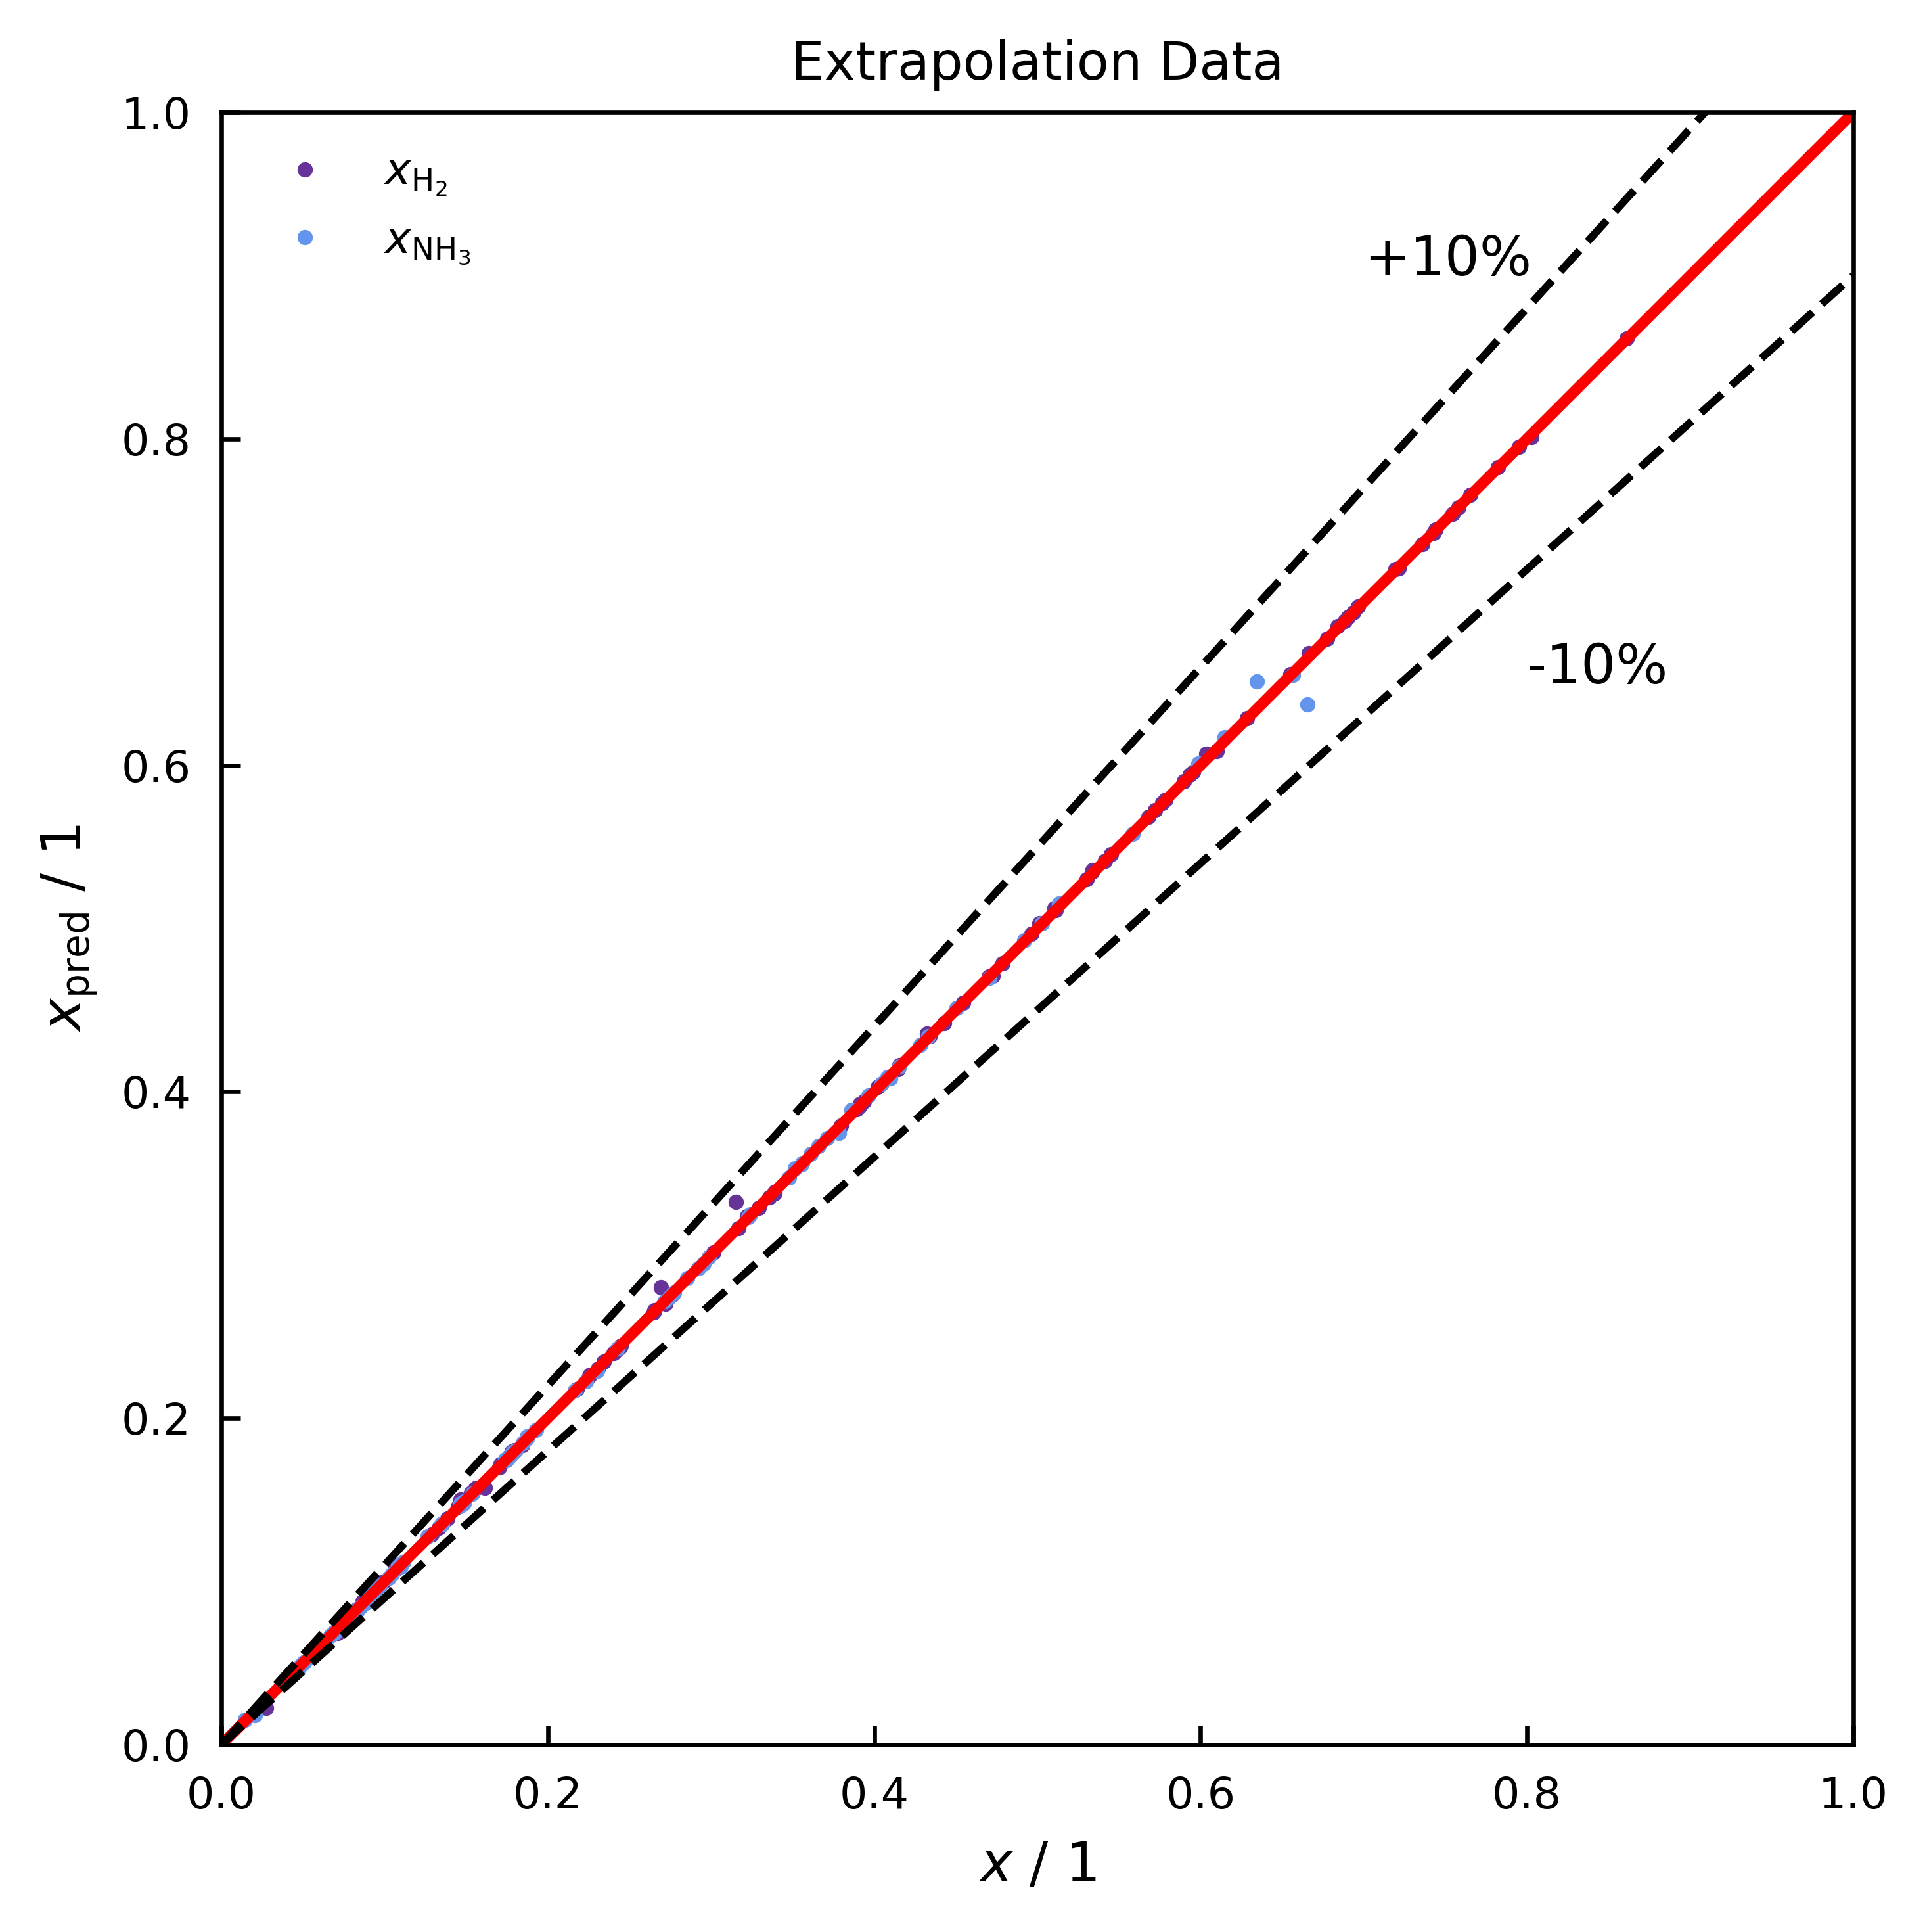

In [9]:
x_H2_real_norm = y_norm[:,0].numpy()
x_NH3_real_norm = y_norm[:,1].numpy()
x_H2_pred_norm, x_NH3_pred_norm = (pred.detach().numpy()).T

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1, figsize =(3.3,3.3))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax.plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax.text(0.7, 0.9, '+10%')
ax.text(0.8, 0.65, '-10%')
ax.set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('Extrapolation Data')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [10]:
# print(X)
# print(y * std_out + mean_out)
# x_H2, x_NH3 = (net(X).detach().numpy()).T
# print(x_H2 * std_out[0].numpy() + mean_out[0].numpy(), ', ', x_NH3 * std_out[1].numpy() + mean_out[1].numpy())

### Wie weit extrapolierbar?

#### Laden und Preprocessing der Daten; p = const; x_0 = const

In [11]:
# Daten Extrapolation
eq_data_file_T_var_extra_haber_picaso = Path.cwd().parent / 'data' / 'eq_dataset_T_var_extra_haber_picaso.npz' #Import der GGW Daten
data_T_extra_haber_picaso = np.load(eq_data_file_T_var_extra_haber_picaso)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[NH3]
T = torch.tensor(data_T_extra_haber_picaso['T'])
p = torch.tensor(data_T_extra_haber_picaso['p'])
x_0 = torch.tensor(data_T_extra_haber_picaso['x_0'])
x = torch.tensor(data_T_extra_haber_picaso['x'])

#p[5,10,30,80,90,100,150,250] bar
X_1 = torch.stack((T, torch.full_like(T, p[0]) , torch.full_like(T, x_0[0]),torch.full_like(T, x_0[1]),torch.full_like(T, x_0[2])),1)
y_1 = x[:,0] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_2 = torch.stack((T, torch.full_like(T, p[1]) , torch.full_like(T, x_0[0]),torch.full_like(T, x_0[1]),torch.full_like(T, x_0[2])),1)
y_2 = x[:,1] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_3 = torch.stack((T, torch.full_like(T, p[2]) , torch.full_like(T, x_0[0]),torch.full_like(T, x_0[1]),torch.full_like(T, x_0[2])),1)
y_3 = x[:,2] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_4 = torch.stack((T, torch.full_like(T, p[3]) , torch.full_like(T, x_0[0]),torch.full_like(T, x_0[1]),torch.full_like(T, x_0[2])),1)
y_4 = x[:,3] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_5 = torch.stack((T, torch.full_like(T, p[4]) , torch.full_like(T, x_0[0]),torch.full_like(T, x_0[1]),torch.full_like(T, x_0[2])),1)
y_5 = x[:,4] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_6 = torch.stack((T, torch.full_like(T, p[5]) , torch.full_like(T, x_0[0]),torch.full_like(T, x_0[1]),torch.full_like(T, x_0[2])),1)
y_6 = x[:,5] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_7 = torch.stack((T, torch.full_like(T, p[6]) , torch.full_like(T, x_0[0]),torch.full_like(T, x_0[1]),torch.full_like(T, x_0[2])),1)
y_7 = x[:,6] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_8 = torch.stack((T, torch.full_like(T, p[7]) , torch.full_like(T, x_0[0]),torch.full_like(T, x_0[1]),torch.full_like(T, x_0[2])),1)
y_8 = x[:,7] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_9 = torch.stack((T, torch.full_like(T, p[8]) , torch.full_like(T, x_0[0]),torch.full_like(T, x_0[1]),torch.full_like(T, x_0[2])),1)
y_9 = x[:,8] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
# print(X)

X_1_norm = (X_1 - mean_in) / std_in
y_1_norm = (y_1 - mean_out[1]) / std_out[1]
X_2_norm = (X_2 - mean_in) / std_in
y_2_norm = (y_2 - mean_out[1]) / std_out[1]
X_3_norm = (X_3 - mean_in) / std_in
y_3_norm = (y_3 - mean_out[1]) / std_out[1]
X_4_norm = (X_4 - mean_in) / std_in
y_4_norm = (y_4 - mean_out[1]) / std_out[1]
X_5_norm = (X_5 - mean_in) / std_in
y_5_norm = (y_5 - mean_out[1]) / std_out[1]
X_6_norm = (X_6 - mean_in) / std_in
y_6_norm = (y_6 - mean_out[1]) / std_out[1]
X_7_norm = (X_7 - mean_in) / std_in
y_7_norm = (y_7 - mean_out[1]) / std_out[1]
X_8_norm = (X_8 - mean_in) / std_in
y_8_norm = (y_8 - mean_out[1]) / std_out[1]
X_9_norm = (X_9 - mean_in) / std_in
y_9_norm = (y_9 - mean_out[1]) / std_out[1]
# print(X_norm)
# print(mean_in)

#### Vorhersage der GGW Daten

In [12]:
pred_1 = net(X_1_norm)
pred_2 = net(X_2_norm)
pred_3 = net(X_3_norm)
pred_4 = net(X_4_norm)
pred_5 = net(X_5_norm)
pred_6 = net(X_6_norm)
pred_7 = net(X_7_norm)
pred_8 = net(X_8_norm)
pred_9 = net(X_9_norm)

#### Auswertung Verlauf x_NH3 über T, p =const, x_0 = const, Inter- und Extrapolation

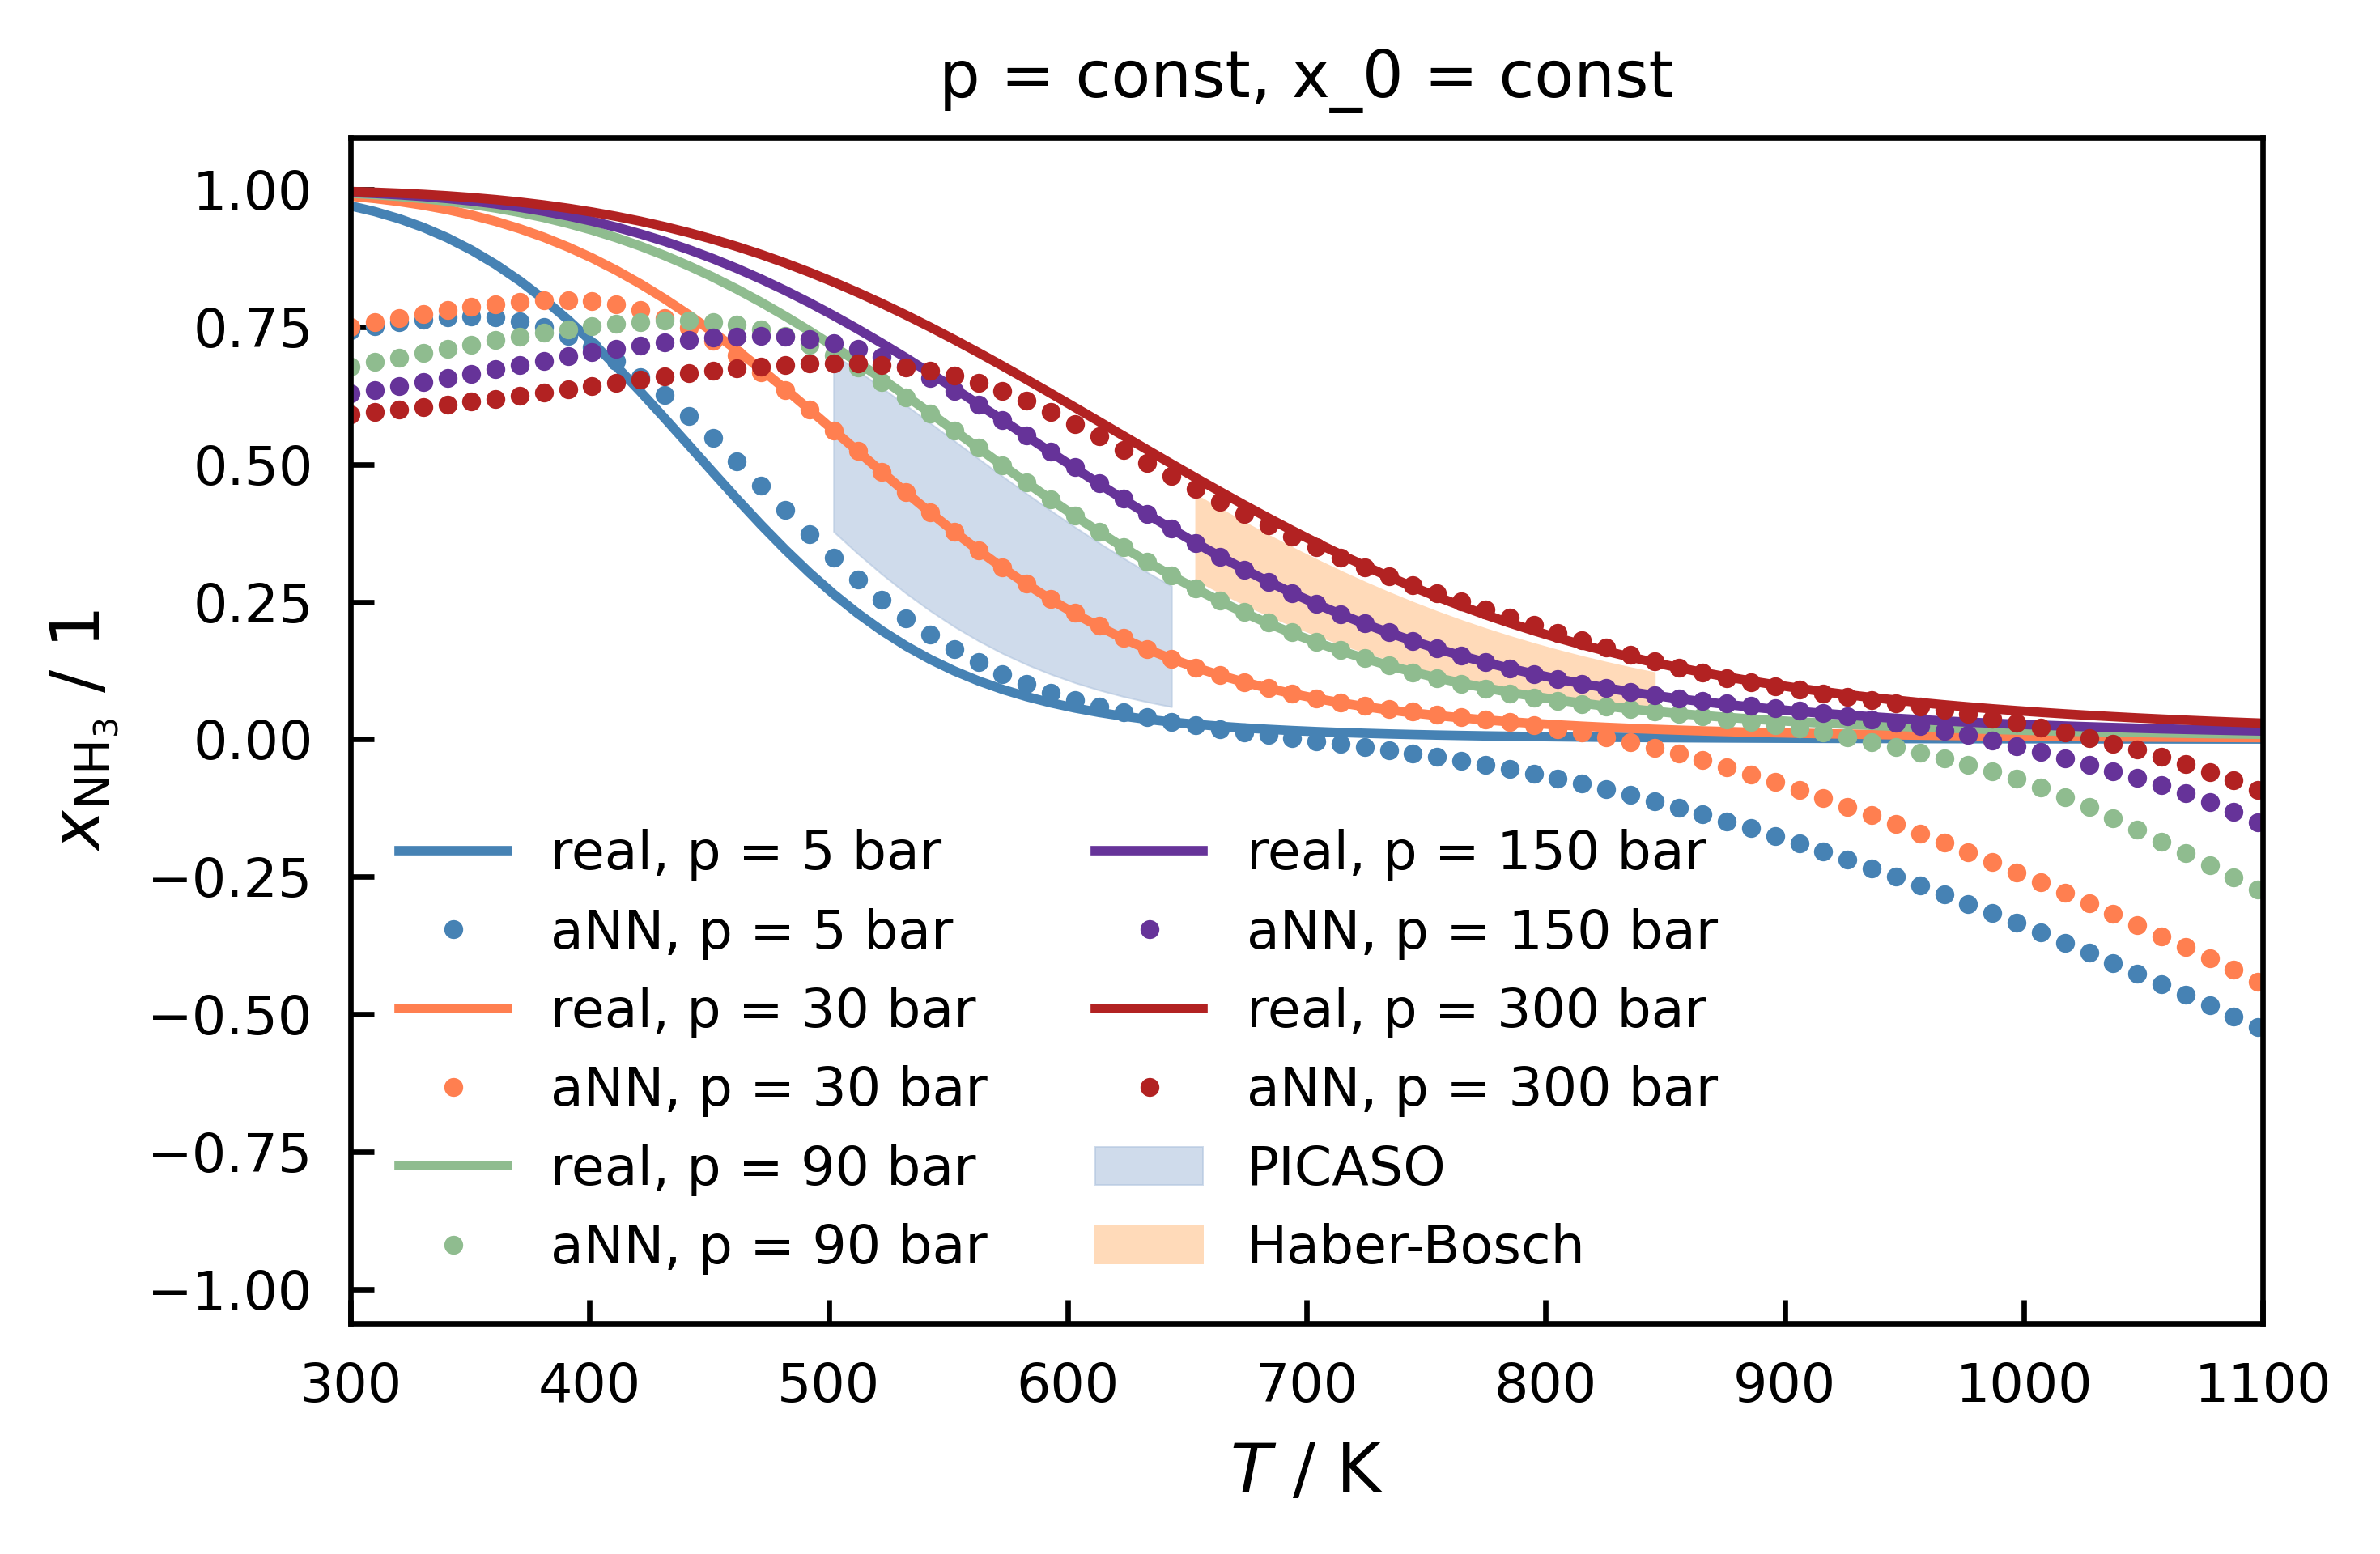

In [13]:
x_NH3_real_norm_1 = y_1_norm.numpy()
_, x_NH3_pred_norm_1 = (pred_1.detach().numpy()).T
x_NH3_real_norm_2 = y_2_norm.numpy()
_, x_NH3_pred_norm_2 = (pred_2.detach().numpy()).T
x_NH3_real_norm_3 = y_3_norm.numpy()
_, x_NH3_pred_norm_3 = (pred_3.detach().numpy()).T
x_NH3_real_norm_4 = y_4_norm.numpy()
_, x_NH3_pred_norm_4 = (pred_4.detach().numpy()).T
x_NH3_real_norm_5 = y_5_norm.numpy()
_, x_NH3_pred_norm_5 = (pred_5.detach().numpy()).T
x_NH3_real_norm_6 = y_6_norm.numpy()
_, x_NH3_pred_norm_6 = (pred_6.detach().numpy()).T
x_NH3_real_norm_7 = y_7_norm.numpy()
_, x_NH3_pred_norm_7 = (pred_7.detach().numpy()).T
x_NH3_real_norm_8 = y_8_norm.numpy()
_, x_NH3_pred_norm_8 = (pred_8.detach().numpy()).T
x_NH3_real_norm_9 = y_9_norm.numpy()
_, x_NH3_pred_norm_9 = (pred_9.detach().numpy()).T

x_NH3_real_1 = x_NH3_real_norm_1 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_1 = x_NH3_pred_norm_1 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real_2 = x_NH3_real_norm_2 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_2 = x_NH3_pred_norm_2 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real_3 = x_NH3_real_norm_3 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_3 = x_NH3_pred_norm_3 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real_4 = x_NH3_real_norm_4 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_4 = x_NH3_pred_norm_4 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real_5 = x_NH3_real_norm_5 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_5 = x_NH3_pred_norm_5 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real_6 = x_NH3_real_norm_6 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_6 = x_NH3_pred_norm_6 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real_7 = x_NH3_real_norm_7 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_7 = x_NH3_pred_norm_7 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real_8 = x_NH3_real_norm_8 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_8 = x_NH3_pred_norm_8 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real_9 = x_NH3_real_norm_9 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_9 = x_NH3_pred_norm_9 * std_out[1].numpy() + mean_out[1].numpy()


fig,ax = plt.subplots()

ax.plot(X_1[:,0], x_NH3_real_1, '-', color ='steelblue', label = 'real, p = 5 bar')
ax.plot(X_1[:,0], x_NH3_pred_1, '.', color ='steelblue', label = 'aNN, p = 5 bar')
#ax.plot(X_2[:,0], x_NH3_real_2, '--', color ='grey')#, label = 'real, p = 10 bar')
#ax.plot(X_2[:,0], x_NH3_pred_2, '.', color ='gold', label = 'aNN, p = 10 bar')
ax.plot(X_3[:,0], x_NH3_real_3, '-', color ='coral', label = 'real, p = 30 bar')
ax.plot(X_3[:,0], x_NH3_pred_3, '.', color ='coral', label = 'aNN, p = 30 bar')
#ax.plot(X_4[:,0], x_NH3_real_4, '--', color ='grey')#, label = 'real, p = 80 bar')
#ax.plot(X_4[:,0], x_NH3_pred_4, '.', color ='mediumorchid', label = 'aNN, p = 80 bar')
ax.plot(X_5[:,0], x_NH3_real_5, '-', color ='darkseagreen', label = 'real, p = 90 bar')
ax.plot(X_5[:,0], x_NH3_pred_5, '.', color ='darkseagreen', label = 'aNN, p = 90 bar')
#ax.plot(X_6[:,0], x_NH3_real_6, '--', color ='grey')#, label = 'real, p = 100 bar')
#ax.plot(X_6[:,0], x_NH3_pred_6, '.', color ='yellowgreen', label = 'aNN, p = 100 bar')
ax.plot(X_7[:,0], x_NH3_real_7, '-', color ='rebeccapurple', label = 'real, p = 150 bar')
ax.plot(X_7[:,0], x_NH3_pred_7, '.', color ='rebeccapurple', label = 'aNN, p = 150 bar')
#ax.plot(X_8[:,0], x_NH3_real_8, '--', color ='grey')#, label = 'real, p = 250 bar')
#ax.plot(X_8[:,0], x_NH3_pred_8, '.', color ='yellowgreen', label = 'aNN, p = 250 bar')
ax.plot(X_9[:,0], x_NH3_real_9, '-', color ='firebrick', label = 'real, p = 300 bar')
ax.plot(X_9[:,0], x_NH3_pred_9, '.', color ='firebrick', label = 'aNN, p = 300 bar')

#ax.axvline(x=500, color='black', linestyle='dashed')
#ax.axvline(x=650, color='black', linestyle='dashed')
#ax.axvline(x=850, color='black', linestyle='dashed')


ax.set(xlabel = '$T$ / K', ylabel = '$x\mathregular{_{NH_3}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('p = const, x_0 = const')
ax.set(xlim=(300,1100))

#fill in training arreas
X_help = X_2.numpy()
index_500 = np.where(X_help[:,0] >= 500)[0][0]
index_650 = np.where(X_help[:,0] >= 650)[0][0]
index_850 = np.where(X_help[:,0] >= 850)[0][0]

# print(index_500)
# print(X_2[index_500:index_650,0])
ax.fill_between(X_2[index_500:index_650, 0],x_NH3_real_2[index_500:index_650], x_NH3_real_4[index_500:index_650], color = 'lightsteelblue', label = 'PICASO', alpha = 0.6)
ax.fill_between(X_2[index_650:index_850, 0],x_NH3_real_6[index_650:index_850], x_NH3_real_8[index_650:index_850], color = 'peachpuff', label = 'Haber-Bosch')#,alpha = 0.6)

ax.legend(ncols = 2)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Parity Plot

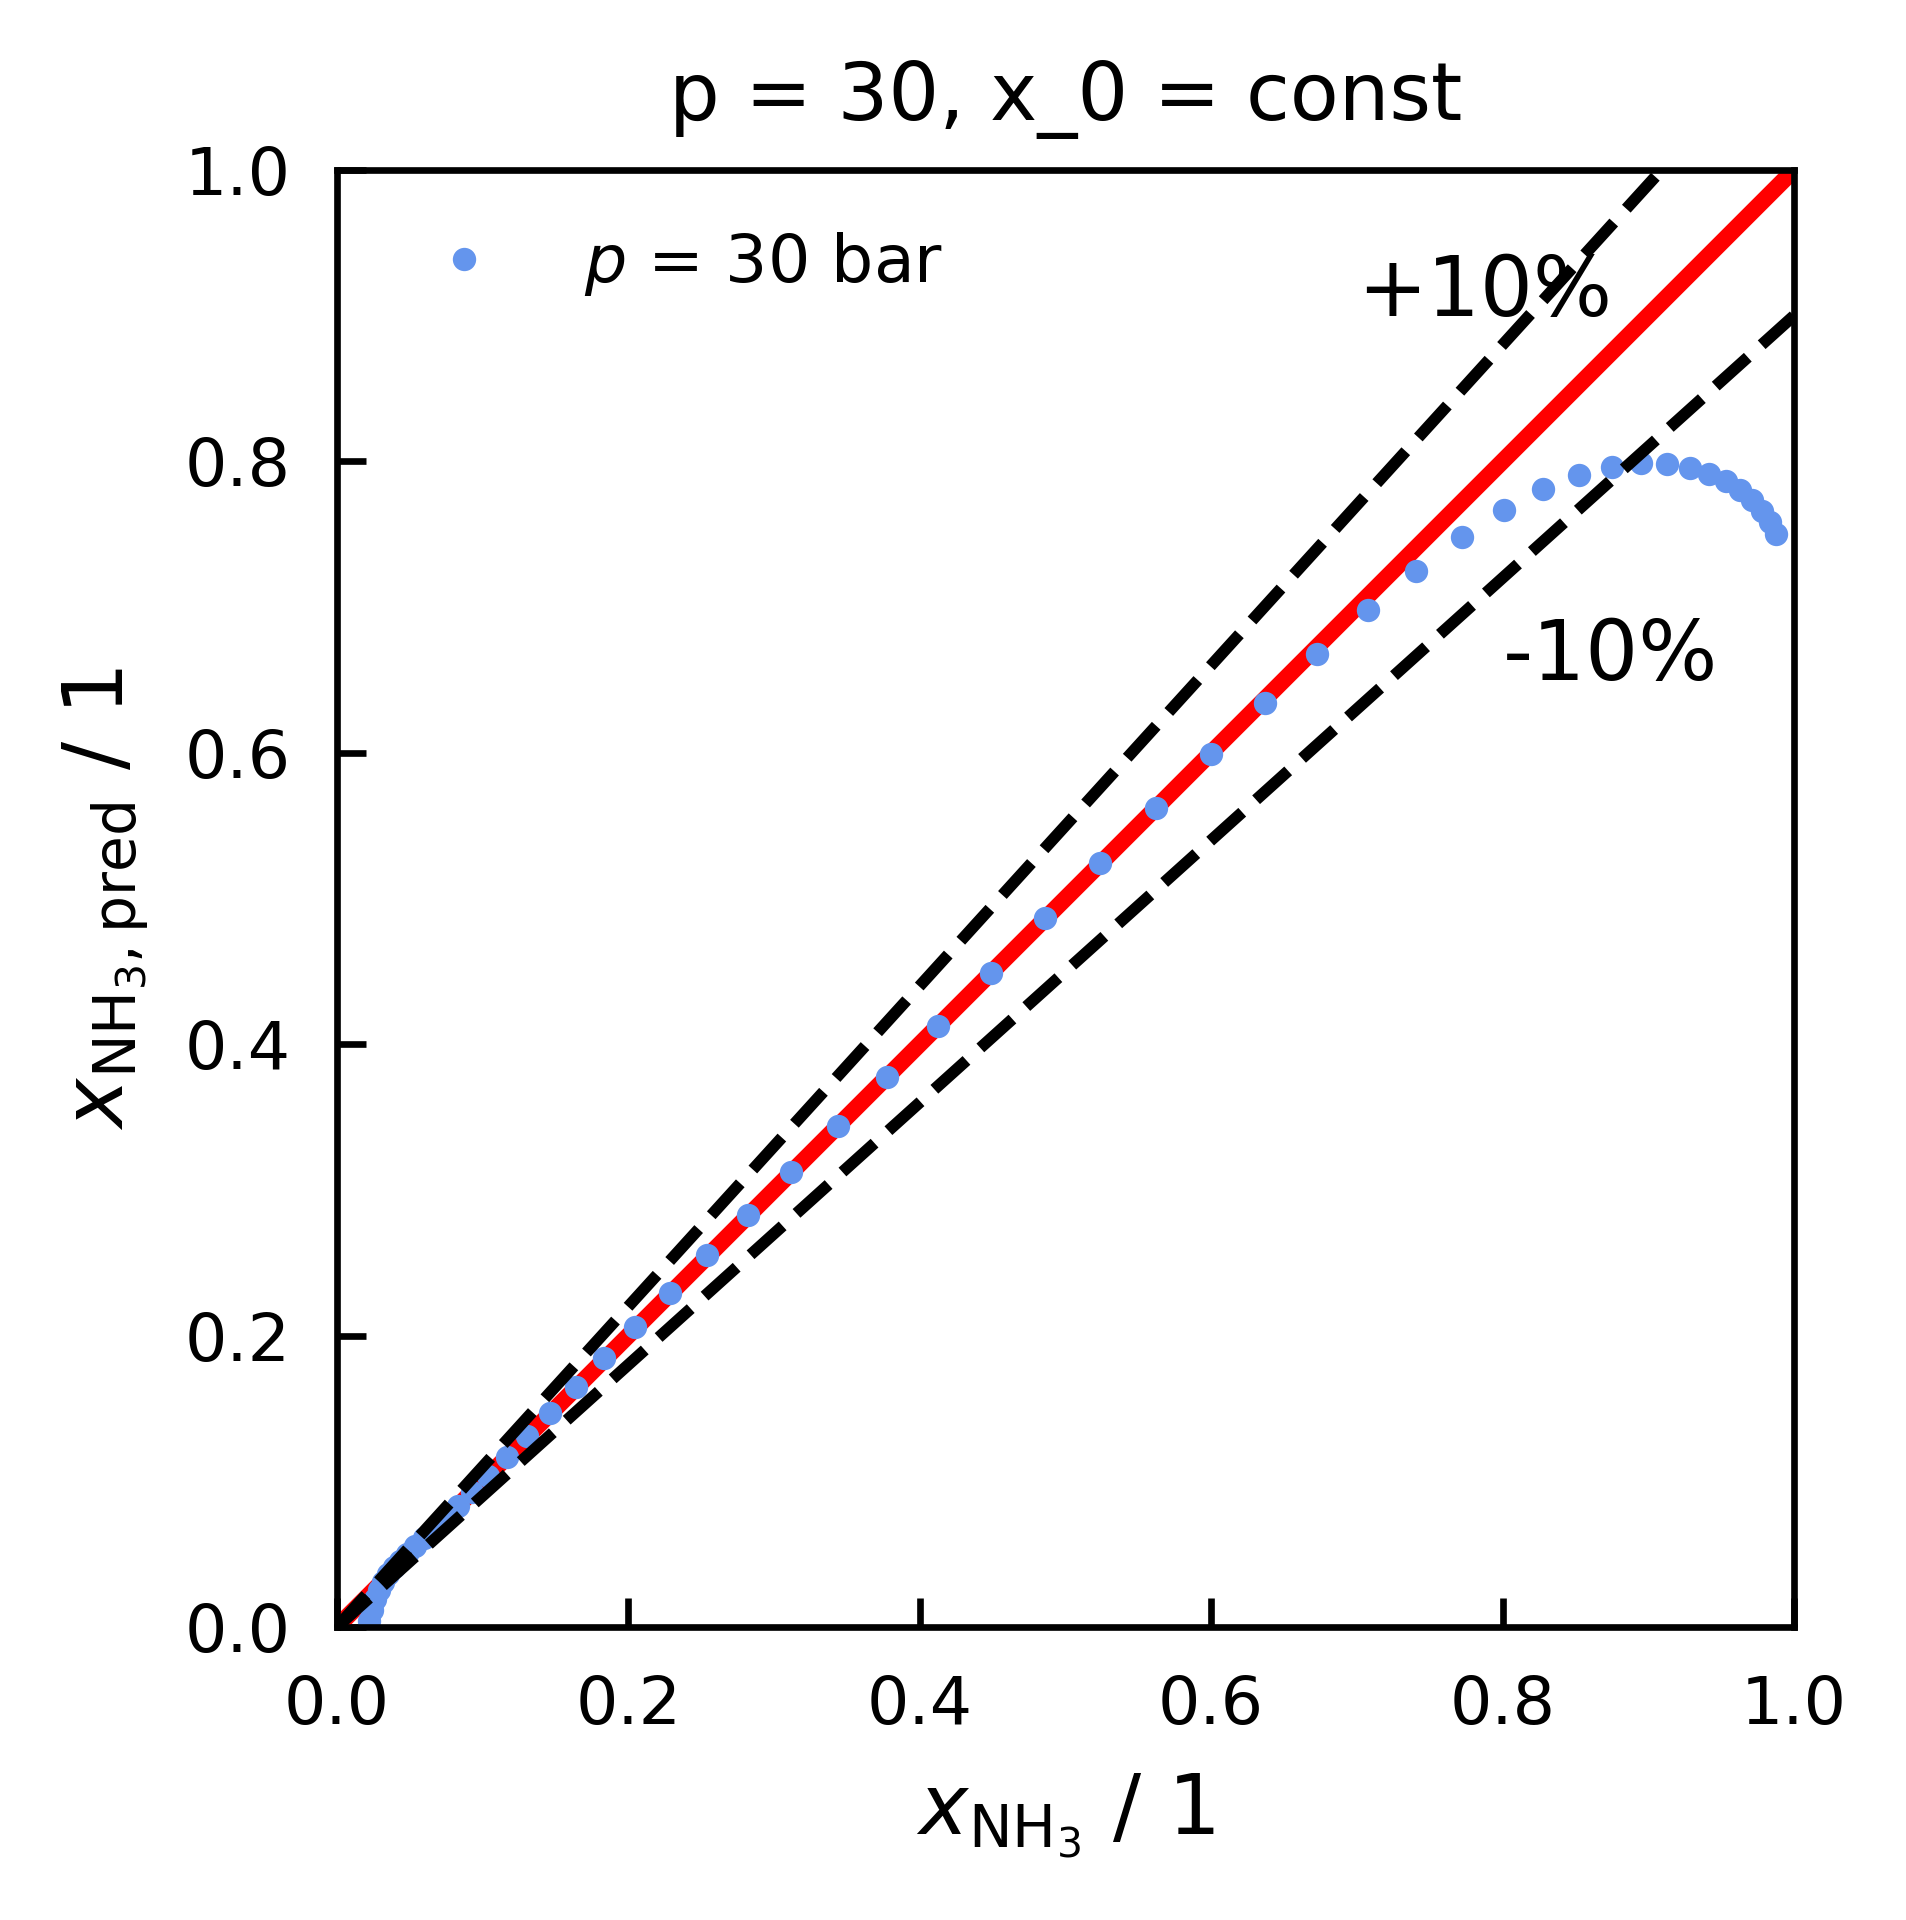

In [14]:
# Set the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1, figsize =(3.3,3.3))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)
ax.plot(x_NH3_real_3, x_NH3_pred_3, '.', color ='cornflowerblue', label = '$p$ = 30 bar')
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax.text(0.7, 0.9, '+10%')
ax.text(0.8, 0.65, '-10%')
ax.set(xlabel = '$x\mathregular{_{NH_3}}$ / 1', ylabel = '$x\mathregular{_{NH_{3},pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('p = 30, x_0 = const')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Laden und Preprocessing der Daten; T = const, x_0 = const

In [15]:
# Daten Extrapolation
eq_data_file_p_var_extra_haber = Path.cwd().parent / 'data' / 'eq_dataset_p_var_extra_haber_picaso.npz' #Import der GGW Daten
data_p_extra_haber = np.load(eq_data_file_p_var_extra_haber)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[NH3]
T = torch.tensor(data_p_extra_haber['T'])
p = torch.tensor(data_p_extra_haber['p'])
x_0 = torch.tensor(data_p_extra_haber['x_0'])
x = torch.tensor(data_p_extra_haber['x'])

#T[450,500,600,650,750,850,900] K
X_1 = torch.stack((torch.full_like(p, T[0]), p, torch.full_like(p, x_0[0]),torch.full_like(p, x_0[1]),torch.full_like(p, x_0[2])),1)
y_1 = x[:,0] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_2 = torch.stack((torch.full_like(p, T[1]), p, torch.full_like(p, x_0[0]),torch.full_like(p, x_0[1]),torch.full_like(p, x_0[2])),1)
y_2 = x[:,1] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_3 = torch.stack((torch.full_like(p, T[2]), p, torch.full_like(p, x_0[0]),torch.full_like(p, x_0[1]),torch.full_like(p, x_0[2])),1)
y_3 = x[:,2] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_4 = torch.stack((torch.full_like(p, T[3]), p, torch.full_like(p, x_0[0]),torch.full_like(p, x_0[1]),torch.full_like(p, x_0[2])),1)
y_4 = x[:,3] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_5 = torch.stack((torch.full_like(p, T[4]), p, torch.full_like(p, x_0[0]),torch.full_like(p, x_0[1]),torch.full_like(p, x_0[2])),1)
y_5 = x[:,4] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_6 = torch.stack((torch.full_like(p, T[5]), p, torch.full_like(p, x_0[0]),torch.full_like(p, x_0[1]),torch.full_like(p, x_0[2])),1)
y_6 = x[:,5] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
X_7 = torch.stack((torch.full_like(p, T[6]), p, torch.full_like(p, x_0[0]),torch.full_like(p, x_0[1]),torch.full_like(p, x_0[2])),1)
y_7 = x[:,6] # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
# print(X)

X_1_norm = (X_1 - mean_in) / std_in
y_1_norm = (y_1 - mean_out[1]) / std_out[1]
X_2_norm = (X_2 - mean_in) / std_in
y_2_norm = (y_2 - mean_out[1]) / std_out[1]
X_3_norm = (X_3 - mean_in) / std_in
y_3_norm = (y_3 - mean_out[1]) / std_out[1]
X_4_norm = (X_4 - mean_in) / std_in
y_4_norm = (y_4 - mean_out[1]) / std_out[1]
X_5_norm = (X_5 - mean_in) / std_in
y_5_norm = (y_5 - mean_out[1]) / std_out[1]
X_6_norm = (X_6 - mean_in) / std_in
y_6_norm = (y_6 - mean_out[1]) / std_out[1]
X_7_norm = (X_7 - mean_in) / std_in
y_7_norm = (y_7 - mean_out[1]) / std_out[1]
# print(X_norm)
# print(mean_in)

#### Vorhersage der GGW Daten

In [16]:
pred_1 = net(X_1_norm)
pred_2 = net(X_2_norm)
pred_3 = net(X_3_norm)
pred_4 = net(X_4_norm)
pred_5 = net(X_5_norm)
pred_6 = net(X_6_norm)
pred_7 = net(X_7_norm)

#### Auswertung Verlauf x_NH3 über p, T =const, x_0 = const, Inter- und Extrapolation

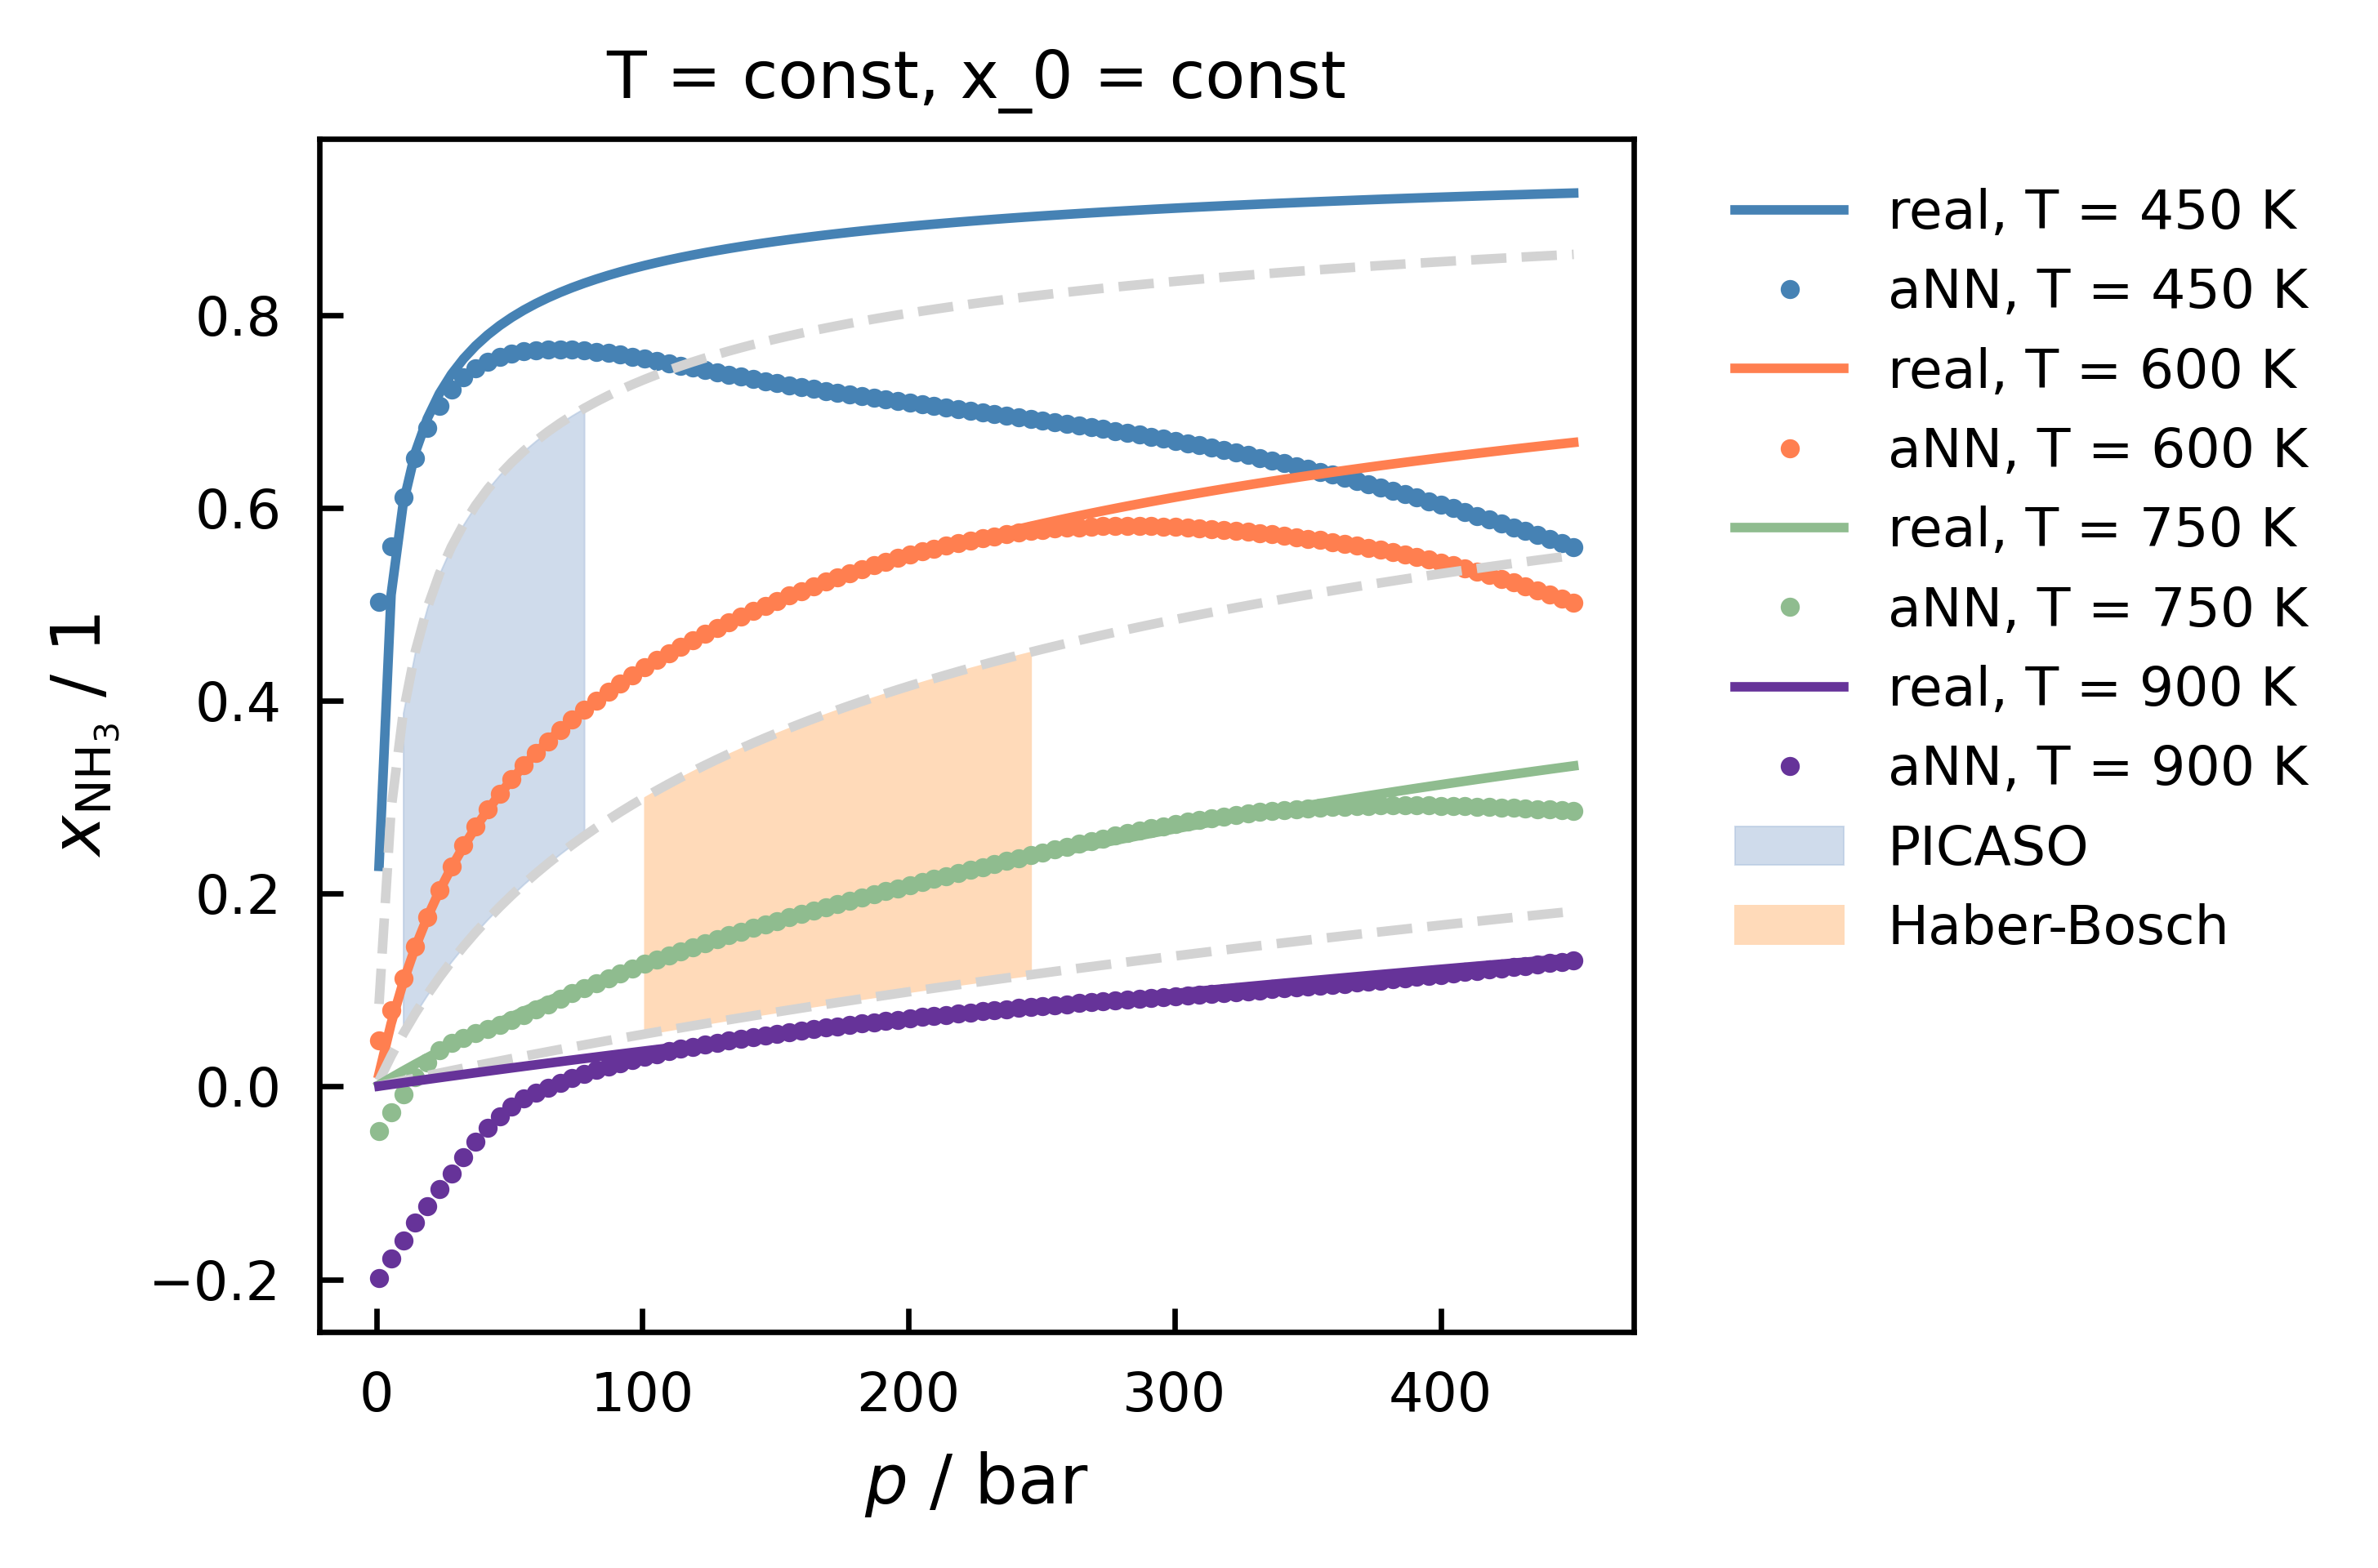

In [19]:
x_NH3_real_norm_1 = y_1_norm.numpy()
_, x_NH3_pred_norm_1 = (pred_1.detach().numpy()).T
x_NH3_real_norm_2 = y_2_norm.numpy()
_, x_NH3_pred_norm_2 = (pred_2.detach().numpy()).T
x_NH3_real_norm_3 = y_3_norm.numpy()
_, x_NH3_pred_norm_3 = (pred_3.detach().numpy()).T
x_NH3_real_norm_4 = y_4_norm.numpy()
_, x_NH3_pred_norm_4 = (pred_4.detach().numpy()).T
x_NH3_real_norm_5 = y_5_norm.numpy()
_, x_NH3_pred_norm_5 = (pred_5.detach().numpy()).T
x_NH3_real_norm_6 = y_6_norm.numpy()
_, x_NH3_pred_norm_6 = (pred_6.detach().numpy()).T
x_NH3_real_norm_7 = y_7_norm.numpy()
_, x_NH3_pred_norm_7 = (pred_7.detach().numpy()).T

x_NH3_real_1 = x_NH3_real_norm_1 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_1 = x_NH3_pred_norm_1 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real_2 = x_NH3_real_norm_2 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_2 = x_NH3_pred_norm_2 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real_3 = x_NH3_real_norm_3 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_3 = x_NH3_pred_norm_3 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real_4 = x_NH3_real_norm_4 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_4 = x_NH3_pred_norm_4 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real_5 = x_NH3_real_norm_5 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_5 = x_NH3_pred_norm_5 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real_6 = x_NH3_real_norm_6 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_6 = x_NH3_pred_norm_6 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real_7 = x_NH3_real_norm_7 * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_7 = x_NH3_pred_norm_7 * std_out[1].numpy() + mean_out[1].numpy()

fig,ax = plt.subplots()

ax.plot(X_1[:,1], x_NH3_real_1, '-', color ='steelblue', label = 'real, T = 450 K')
ax.plot(X_1[:,1], x_NH3_pred_1, '.', color ='steelblue', label = 'aNN, T = 450 K')
ax.plot(X_2[:,1], x_NH3_real_2, '--', color ='lightgrey')#, label = 'real, T = 500 K')
#ax.plot(X_2[:,1], x_NH3_pred_2, '.', color ='gold', label = 'aNN, T = 500 K')
ax.plot(X_3[:,1], x_NH3_real_3, '-', color ='coral', label = 'real, T = 600 K')
ax.plot(X_3[:,1], x_NH3_pred_3, '.', color ='coral', label = 'aNN, T = 600 K')
ax.plot(X_4[:,1], x_NH3_real_4, '--', color ='lightgrey')#, label = 'real, T = 650 K')
#ax.plot(X_4[:,1], x_NH3_pred_4, '.', color ='mediumorchid', label = 'aNN, T = 650 K')
ax.plot(X_5[:,1], x_NH3_real_5, '-', color ='darkseagreen', label = 'real, T = 750 K')
ax.plot(X_5[:,1], x_NH3_pred_5, '.', color ='darkseagreen', label = 'aNN, T = 750 K')
ax.plot(X_6[:,1], x_NH3_real_6, '--', color ='lightgrey')#, label = 'real, T = 850 K')
#ax.plot(X_6[:,1], x_NH3_pred_6, '.', color ='yellowgreen', label = 'aNN, T = 850 K')
ax.plot(X_7[:,1], x_NH3_real_7, '-', color ='rebeccapurple', label = 'real, T = 900 K')
ax.plot(X_7[:,1], x_NH3_pred_7, '.', color ='rebeccapurple', label = 'aNN, T = 900 K')

# ax.axvline(x=10, color='black', linestyle='dashed')
# ax.axvline(x=80, color='black', linestyle='dashed')
# ax.axvline(x=100, color='black', linestyle='dashed')
# ax.axvline(x=250, color='black', linestyle='dashed')


ax.set(xlabel = '$p$ / bar', ylabel = '$x\mathregular{_{NH_3}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('T = const, x_0 = const')
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#fill in training areas
#fill in training arreas
X_help = X_1.numpy()
index_10 = np.where(X_help[:,1] >= 10)[0][0]
index_80 = np.where(X_help[:,1] >= 80)[0][0]
index_100 = np.where(X_help[:,1] >= 100)[0][0]
index_250 = np.where(X_help[:,1] >= 250)[0][0]

# print(index_500)
# print(X_2[index_500:index_650,0])
ax.fill_between(X_1[index_10:index_80, 1],x_NH3_real_2[index_10:index_80], x_NH3_real_4[index_10:index_80], color = 'lightsteelblue', label = 'PICASO', alpha =0.6)
ax.fill_between(X_1[index_100:index_250, 1],x_NH3_real_4[index_100:index_250], x_NH3_real_6[index_100:index_250], color = 'peachpuff', label = 'Haber-Bosch')

#plt.legend()
#fig.suptitle("Parity Plot")
#plt.legend()
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()

#### Parity Plot

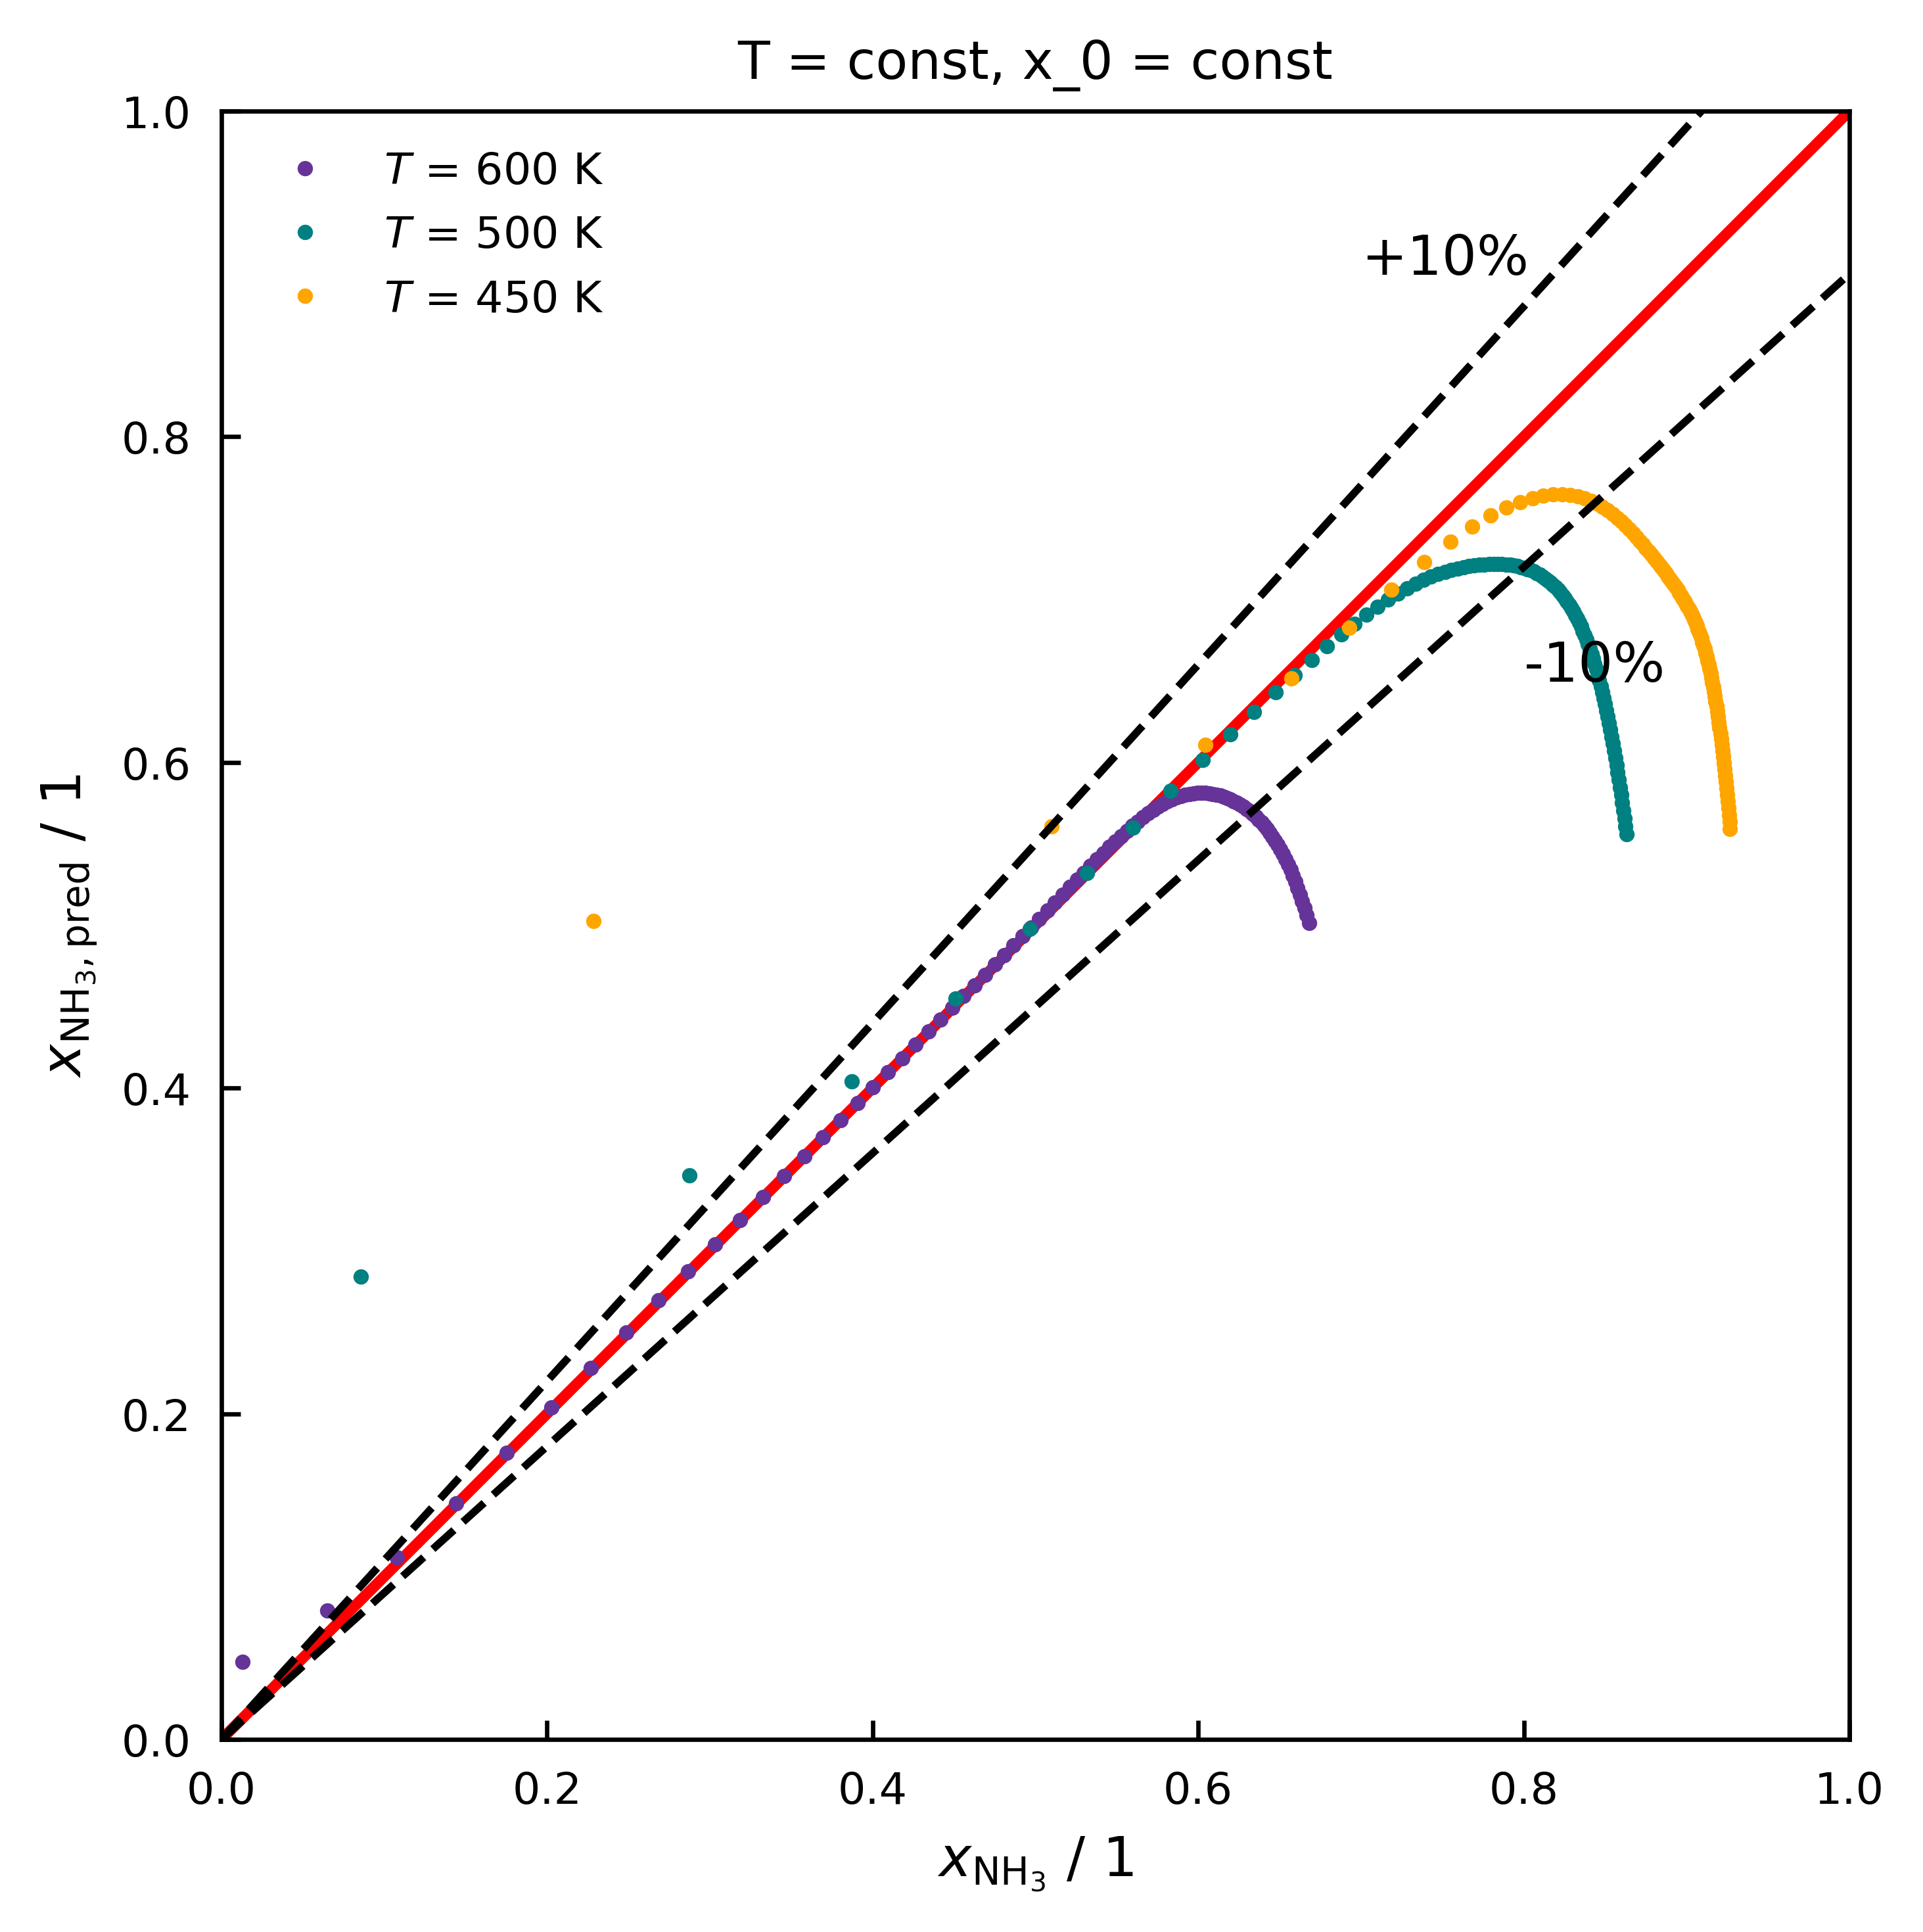

In [18]:
# Set the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1, figsize =(3.3,3.3))

# # Reset the limits
# ax[0] = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)
ax.plot(x_NH3_real_3, x_NH3_pred_3, '.', color ='rebeccapurple', label = '$T$ = 600 K')
ax.plot(x_NH3_real_2, x_NH3_pred_2, '.', color ='teal', label = '$T$ = 500 K')
ax.plot(x_NH3_real_1, x_NH3_pred_1, '.', color ='orange', label = '$T$ = 450 K')
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax.text(0.7, 0.9, '+10%')
ax.text(0.8, 0.65, '-10%')
ax.set(xlabel = '$x\mathregular{_{NH_3}}$ / 1', ylabel = '$x\mathregular{_{NH_{3},pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('T = const, x_0 = const')
ax.legend()
#ax.legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()